In [40]:
import neurokit2 as nk
import torch 
import numpy as np
import io
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.io
import pickle
from PIL import Image

from fairseq_signals.data.ecg.augmentations import RandomLeadsMask

In [31]:
def insert_newline(input_str, max_length):
    """
    Inserts a newline character at the specified maximum length in the input string.
    Parameters:
    - input_str (str): The input string.
    - max_length (int): The maximum number of characters before inserting a newline.
    Returns:
    - str: The modified string with newline characters.
    """
    if len(input_str) > max_length:
        newline_index = max_length
        while newline_index < len(input_str) and input_str[newline_index] != " ":
            newline_index += 1
        if newline_index < len(input_str):
            input_str = input_str[:newline_index] + "\n" + input_str[newline_index:]
    return input_str


def plot_from_npy(
    npy,
    save=False,
    clean=False,
    out_name=None,
    verbose=False,
    scaler=None,
    title="",
    out_dir="/volume",
):
    """
    Plots an EKG for a patient from a given npy path. 
    Actually plot 2 different ECGS. The original, and the 2 split after they have been transformed
    Parameters:
    - npy_path: Parquet file.
    - patient_id: Patient ID (str).
    - date: Date of ECG (str).
    - time: Time of ECG (str).
    - diagnosis_column: Name of the column containing the diagnosis (str).
    - index: Index in parquet to plot (int).
    - save: Saves PNG if True (bool).
    - anonymize: Saves PNG anonymizeously if True (bool).
    - out_dir: Output directory for saving PNG (str).
    Returns:
    - A PNG file or displays the plot.
    """

    # Validate input parameters
    
    lead_order = [
        "I",
        "II",
        "III",
        "aVR",
        "aVL",
        "aVF",
        "V1",
        "V2",
        "V3",
        "V4",
        "V5",
        "V6",
    ]

    #npy = np.swapaxes(np.squeeze(np.load(npy_path)), 0, 1)
    #x = torch.from_numpy(npy)
    #x = F.interpolate(x.unsqueeze(0), 2500, mode='linear')
    #npy = x.squeeze(0).numpy()
    #if clean:
    #    npy = clean_signal(npy)
    #if scaler is not None:
    #    npy = scaler.transform(npy.T).T
    lead_dict = dict(zip(lead_order, npy))
    activation = [0] * 5 + [10] * 50 + [0] * 5
    # generate the pannels
    pannel_1_y = (
        [i + 50 for i in activation]
        + [((i * 4.88) / 100) + 50 for i in lead_dict["I"][60:625]]
        + [((i * 4.88) / 100) + 50 for i in lead_dict["aVR"][625:1250]]
        + [((i * 4.88) / 100) + 50 for i in lead_dict["V1"][1250:1875]]
        + [((i * 4.88) / 100) + 50 for i in lead_dict["V4"][1875:2500]]
    )
    pannel_2_y = (
        [i + 15 for i in activation]
        + [((i * 4.88) / 100) + 15 for i in lead_dict["II"][60:625]]
        + [((i * 4.88) / 100) + 15 for i in lead_dict["aVL"][625:1250]]
        + [((i * 4.88) / 100) + 15 for i in lead_dict["V2"][1250:1875]]
        + [((i * 4.88) / 100) + 15 for i in lead_dict["V5"][1875:2500]]
    )
    pannel_3_y = (
        [i - 15 for i in activation]
        + [((i * 4.88) / 100) - 15 for i in lead_dict["III"][60:625]]
        + [((i * 4.88) / 100) - 15 for i in lead_dict["aVF"][625:1250]]
        + [((i * 4.88) / 100) - 15 for i in lead_dict["V3"][1250:1875]]
        + [((i * 4.88) / 100) - 15 for i in lead_dict["V6"][1875:2500]]
    )
    pannel_4_y = [i - 50 for i in activation] + [
        ((i * 4.88) / 100) - 50 for i in lead_dict["II"][60::]
    ]

    fig, ax = plt.subplots(figsize=(40, 20))
    ax.minorticks_on()
    ratio = 1 if scaler is None else 100
    ratio = 1

    ax.vlines(60, -10/ratio, -20/ratio, label="III", linewidth=4)
    ax.text(60, -10/ratio, "III", fontsize=44)

    ax.vlines(625, -10/ratio, -20/ratio, label="aVF", linewidth=4)
    ax.text(625, -10/ratio, "aVF", fontsize=44)

    ax.vlines(1250, -10/ratio, -20/ratio, label="V3", linewidth=4)
    ax.text(1250, -10/ratio, "V3", fontsize=44)

    ax.vlines(1875, -10/ratio, -20/ratio, label="V6", linewidth=4)
    ax.text(1875, -10/ratio, "V6", fontsize=44)

    ax.vlines(60, 10/ratio, 20/ratio, label="II", linewidth=4)
    ax.text(60, 20/ratio, "II", fontsize=44)

    ax.vlines(625, 10/ratio, 20/ratio, label="aVL", linewidth=4)
    ax.text(625, 20/ratio, "aVL", fontsize=44)

    ax.vlines(1250, 10/ratio, 20/ratio, label="V2", linewidth=4)
    ax.text(1250, 20/ratio, "V2", fontsize=44)

    ax.vlines(1875, 10/ratio, 20/ratio, label="V5", linewidth=4)
    ax.text(1875, 20/ratio, "V5", fontsize=44)

    ax.vlines(60, 45/ratio, 55/ratio, label="I", linewidth=4)
    ax.text(60, 55/ratio, "I", fontsize=44)

    ax.vlines(625, 45/ratio, 55/ratio, label="aVR", linewidth=4)
    ax.text(625, 55/ratio, "aVR", fontsize=44)

    ax.vlines(1250, 45/ratio, 55/ratio, label="V1", linewidth=4)
    ax.text(1250, 55/ratio, "V1", fontsize=44)

    ax.vlines(1875, 45/ratio, 55/ratio, label="V4", linewidth=4)
    ax.text(1875, 55/ratio, "V4", fontsize=44)

    ax.vlines(60, -55/ratio, -45/ratio, label="II", linewidth=4)
    ax.text(60, -45/ratio, "II", fontsize=44)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

    ax.grid(ls="-", color="red", linewidth=1.2)
    ax.grid(which="minor", ls=":", color="red", linewidth=1)

    ax.axis([0 - 100, 2500 + 100, min(pannel_4_y) - 10, max(pannel_1_y) + 10])

    x = [pos for pos in range(0, len(pannel_1_y))]
    ax.plot(x, pannel_1_y, linewidth=3, color="#000000")
    ax.plot(x, pannel_2_y, linewidth=3, color="#000000")
    ax.plot(x, pannel_3_y, linewidth=3, color="#000000")
    ax.plot(x, pannel_4_y, linewidth=3, color="#000000")

    ax.set_title(
        insert_newline(title, 150),
        fontsize=30,
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round,pad=0.3"),
    )

    # add grid
    plt.tight_layout()

    if save == True:
        if out_name is not None:
            plt.savefig(os.path.join(out_dir, f"{out_name}.png"))
        elif anonymize == False:
            plt.savefig(os.path.join(out_dir, f"{patient_id}_{date}_{time}.png"))
        else:
            current_time = time.strftime("%Y%m%d-%H%M%S")
            plt.savefig(os.path.join(out_dir, f"ECG_{current_time}.png"))

    else:
        plt.show()
    # Set the background color to be transparent
    fig.patch.set_alpha(0)

    # Create a BytesIO object to store the plot image
    img_buffer = io.BytesIO()

    # Save the plot to the BytesIO object with transparent background
    plt.savefig(img_buffer, format="png", transparent=True)

    # Seek the BytesIO object to the beginning
    img_buffer.seek(0)

    # Create a PIL Image from the BytesIO object
    img = Image.open(img_buffer)

    # Close the plot to free up memory
    plt.close()

    return img

/root/miniconda3/lib/python3.8/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


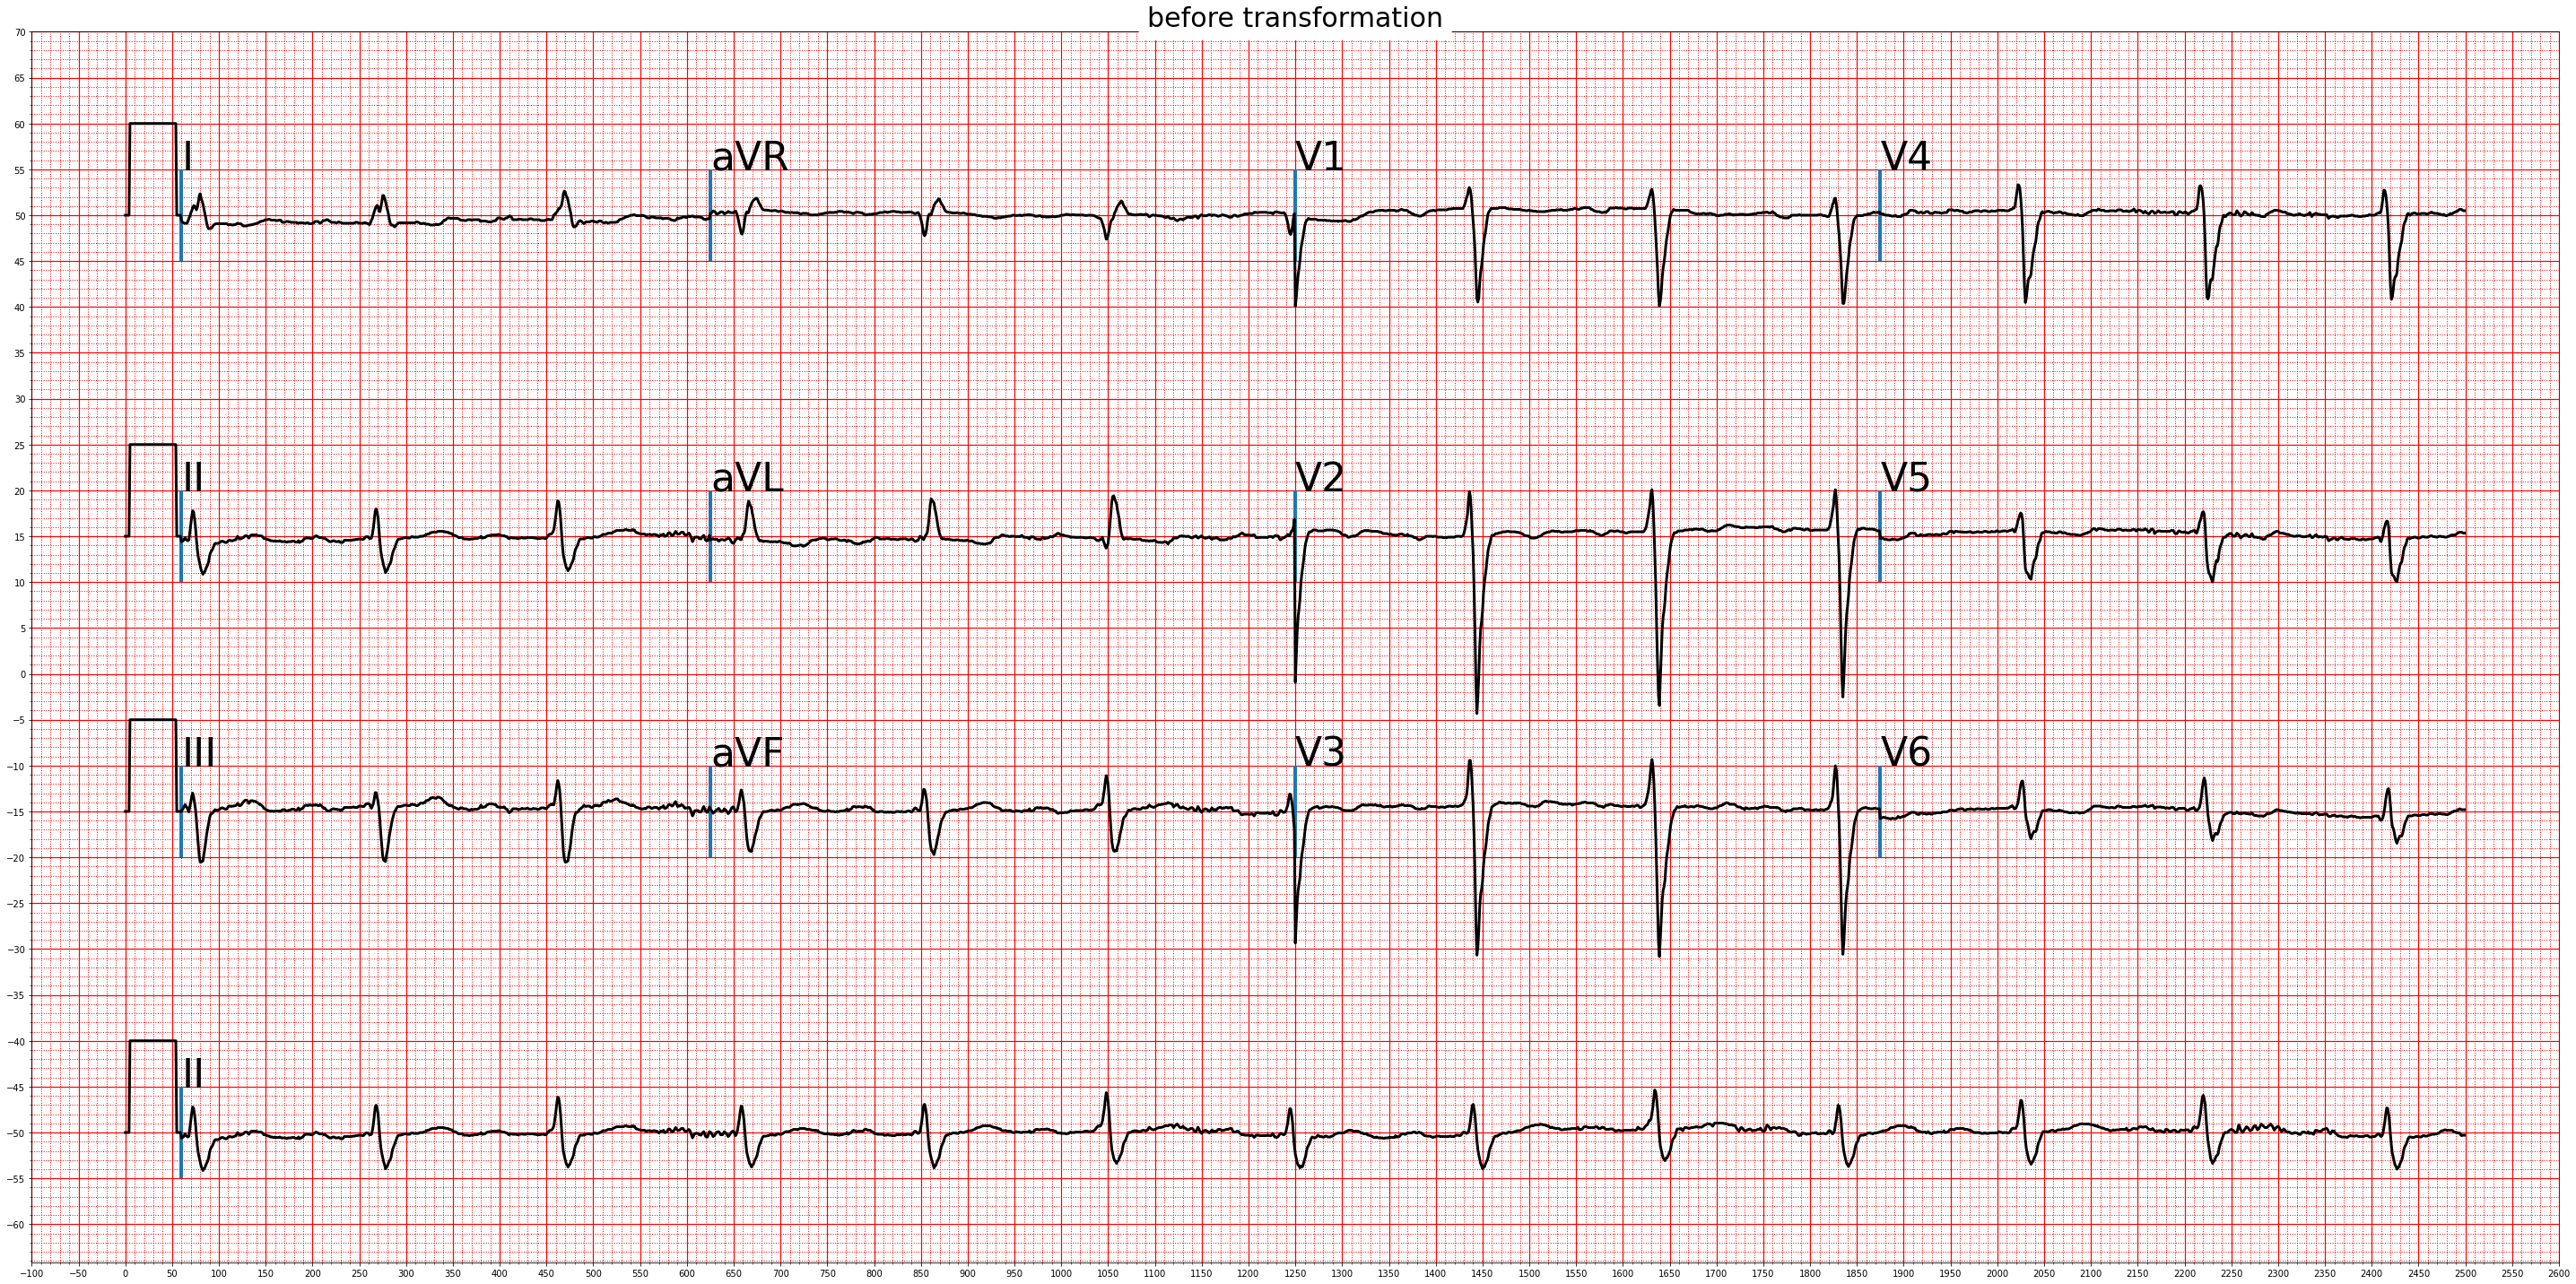

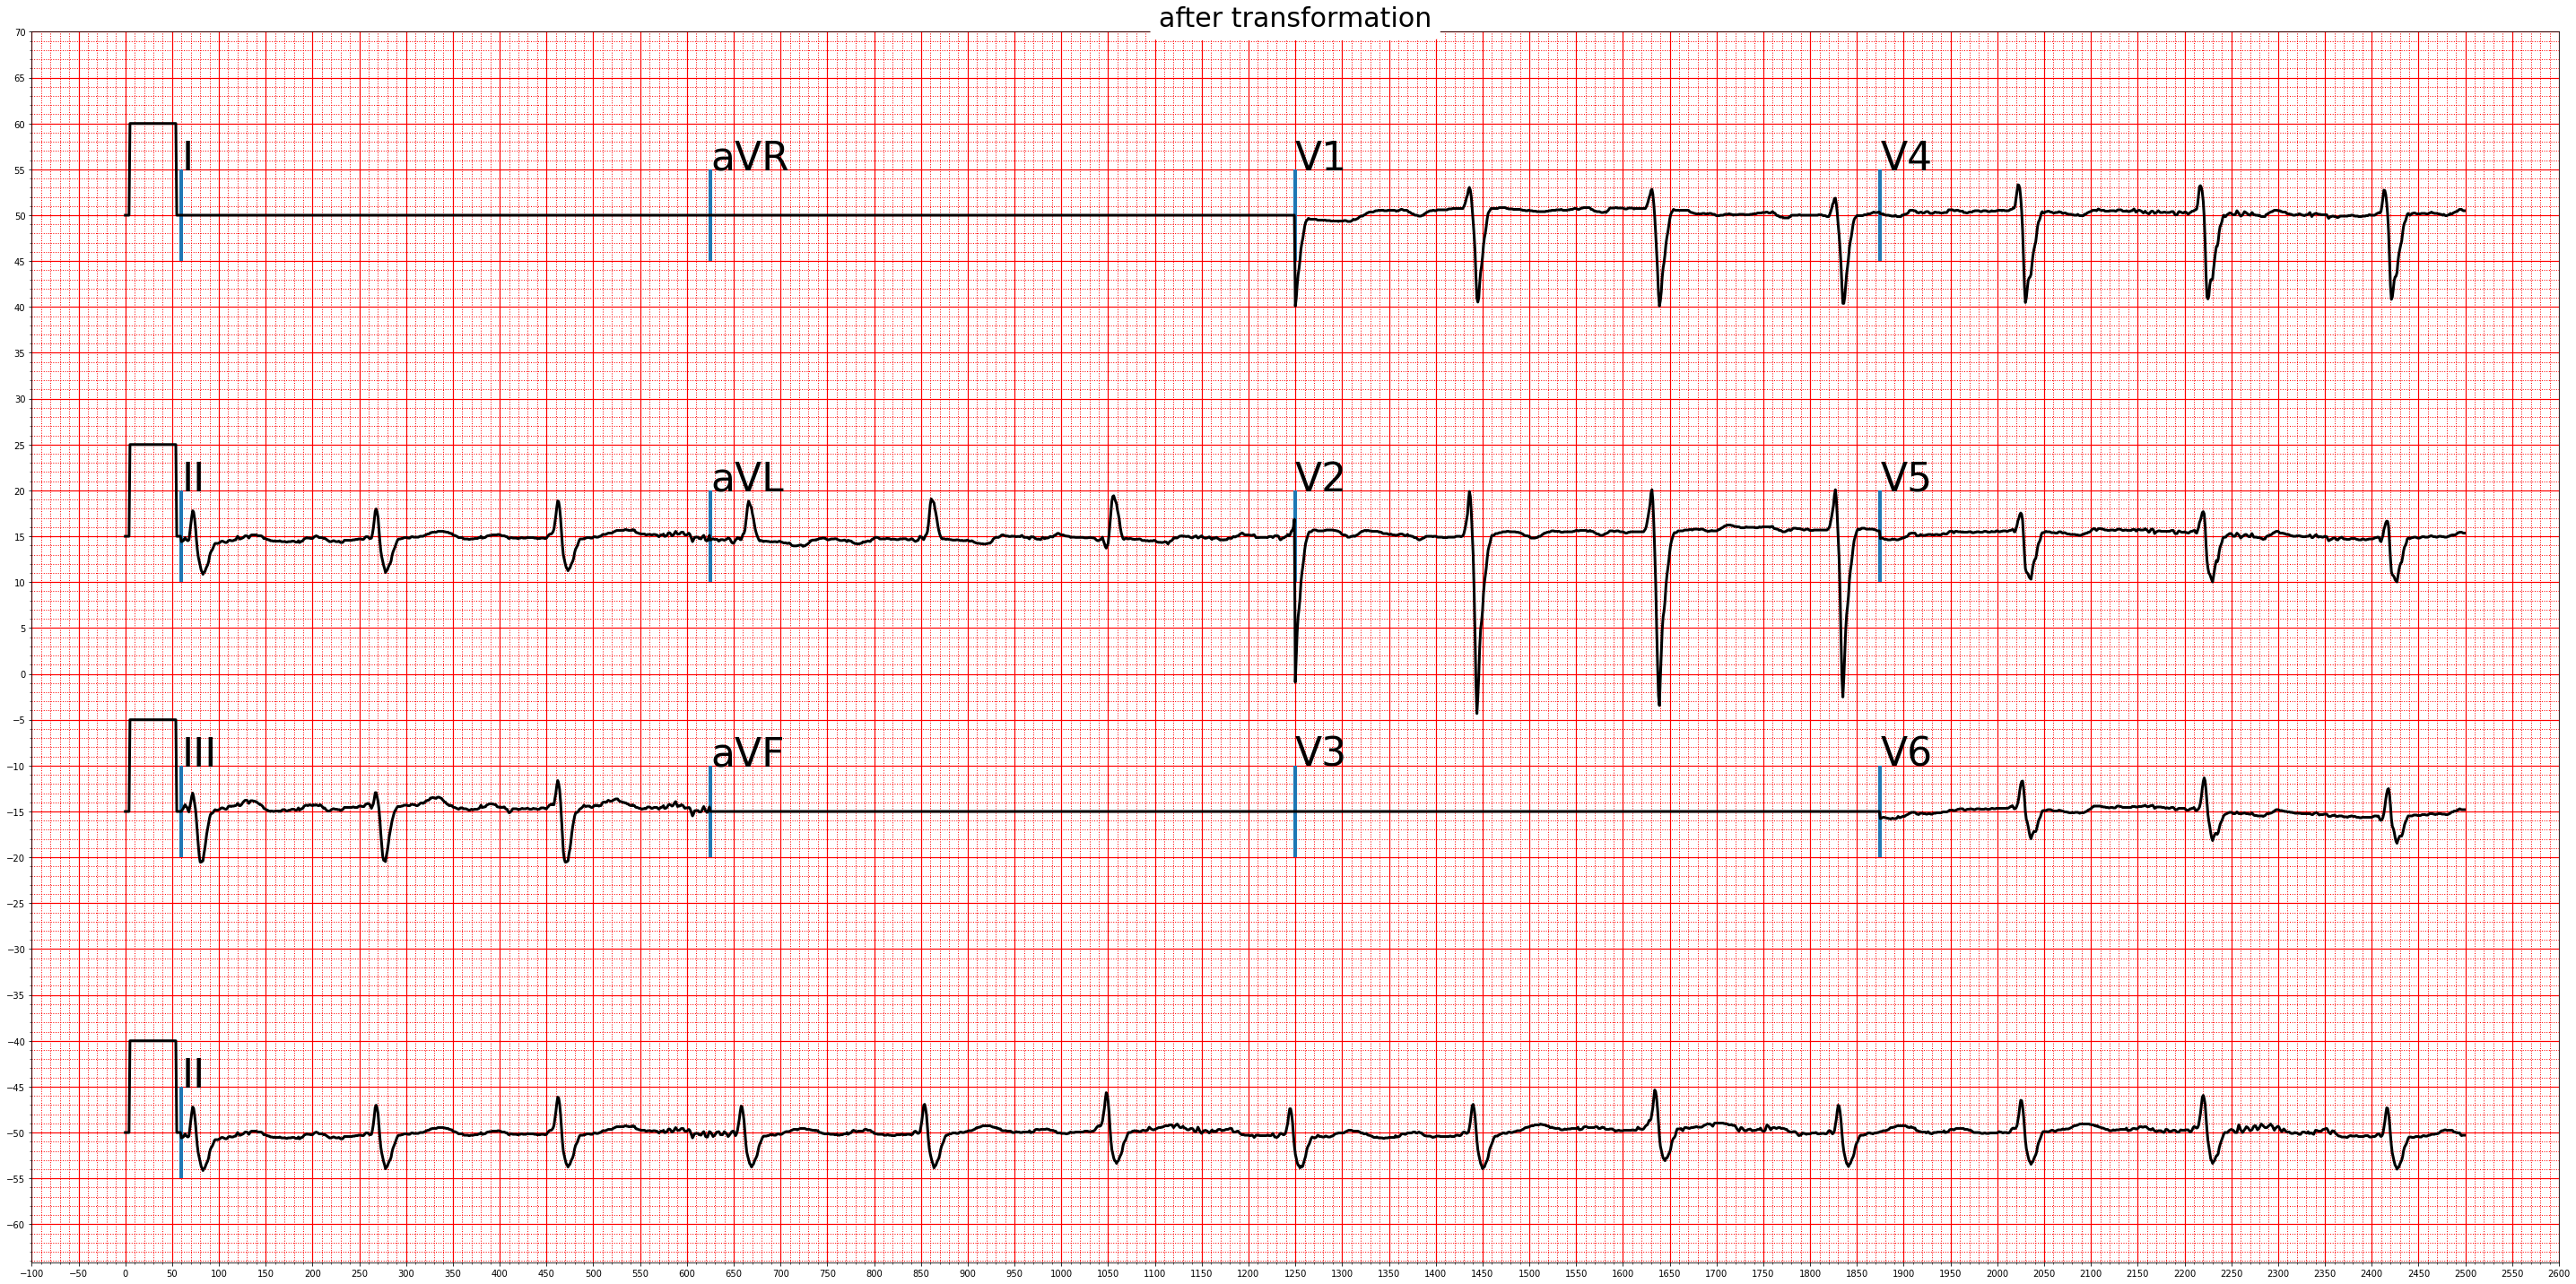

In [50]:
with open('/volume/deepecg/ecgs-data/scaler/scaler_mhi_train_12c.pkl', 'rb') as file:
    scaler = pickle.load(file)

mat_path = "/volume/deepecg/ecgs-data/fairseq/mhi/train/0000001000/0001010_01-16-2020_13-38-42.npy"


def plot_ecgs(mat_path):

    rlm = RandomLeadsMask()    
    mat0 = scipy.io.loadmat(f'{mat_path}_0.mat')
    mat1 = scipy.io.loadmat(f'{mat_path}_1.mat')
    ecg0 = scaler.inverse_transform(mat0['feats'].T).T
    ecg1 = scaler.inverse_transform(mat1['feats'].T).T
    ecg = np.concatenate([ecg0, ecg1], axis=1)
    img = plot_from_npy(ecg, title="before transformation")

    x0 = rlm(torch.from_numpy(ecg0))
    x1 = rlm(torch.from_numpy(ecg1))
    ecg = np.concatenate([x0.numpy(), x1.numpy()], axis=1)
    img = plot_from_npy(ecg, title="after transformation")


plot_ecgs(mat_path)